# Testing
### Wohnungsbestand nach Art des Energieträgers, Statistischer Zone und Bauperiode seit 2017

Diese Daten umfassen den Wohnungsbestand der Stadt Zürich nach Art des Energieträgers. Die Daten liegen ab dem Jahr 2017 jährlich vor.
Datum: 07.02.2022

### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [3]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [4]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [5]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 2 datenstand:  0 time.struct_time(tm_year=2022, tm_mon=2, tm_mday=7, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=38, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [6]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_best_whg_energietraegerart_statzone_seit2017_od5331


**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_best_whg_energietraegerart_statzone_seit2017_od5331



In [8]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ";
print(status)

integ


In [9]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bau_best_whg_energietraegerart_statzone_seit2017_od5331/download/BAU533OD5331.csv"
else:
    fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bau_best_whg_energietraegerart_statzone_seit2017_od5331/BAU533OD5331.csv"   

print(fp)

//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bau_best_whg_energietraegerart_statzone_seit2017_od5331/BAU533OD5331.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [10]:
# Read the data
data2betested = pd.read_csv(
    fp
    , sep=','
    ,parse_dates=['Jahr']
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [11]:
#data2betested

In [12]:
data2betested.dtypes

Jahr            datetime64[ns]
StatZoneSort             int64
StatZoneLang            object
QuarSort                 int64
QuarLang                object
KreisSort                int64
KreisLang               object
Bauperiode              object
Heizöl                   int64
Gas                      int64
Holz                     int64
Wärmepumpe               int64
Fernwärme                int64
Andere                   int64
dtype: object

In [13]:
data2betested.shape

(8322, 14)

Beschreibe einzelne Attribute

In [14]:
data2betested.describe()

,StatZoneSort,QuarSort,KreisSort,Heizöl,Gas,Holz,Wärmepumpe,Fernwärme,Andere
count,8322,8322,8322,8322,8322,8322,8322,8322,8322
mean,110,69,7,33,67,1,11,23,0
std,62,34,3,73,140,17,45,82,5
min,1,11,1,0,0,0,0,0,0
25%,57,34,3,0,0,0,0,0,0
50%,110,72,7,1,13,0,0,0,0
75%,163,101,10,34,68,0,5,0,0
max,216,123,12,1123,1433,513,1118,1090,191


Wie viele Nullwerte gibt es im Datensatz?

In [15]:
data2betested.isnull().sum()


Jahr            0
StatZoneSort    0
StatZoneLang    0
QuarSort        0
QuarLang        0
KreisSort       0
KreisLang       0
Bauperiode      0
Heizöl          0
Gas             0
Holz            0
Wärmepumpe      0
Fernwärme       0
Andere          0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [16]:
data2betested = data2betested.set_index("Jahr")

In [17]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8322 entries, 2017-01-01 to 2021-01-01
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   StatZoneSort  8322 non-null   int64 
 1   StatZoneLang  8322 non-null   object
 2   QuarSort      8322 non-null   int64 
 3   QuarLang      8322 non-null   object
 4   KreisSort     8322 non-null   int64 
 5   KreisLang     8322 non-null   object
 6   Bauperiode    8322 non-null   object
 7   Heizöl        8322 non-null   int64 
 8   Gas           8322 non-null   int64 
 9   Holz          8322 non-null   int64 
 10  Wärmepumpe    8322 non-null   int64 
 11  Fernwärme     8322 non-null   int64 
 12  Andere        8322 non-null   int64 
dtypes: int64(9), object(4)
memory usage: 910.2+ KB


Int64Index([1], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [18]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [23]:
data2betested.loc["2017":"2021"].query('Bauperiode != "nach 2010"').head(2)

,StatZoneSort,StatZoneLang,QuarSort,QuarLang,KreisSort,KreisLang,Bauperiode,Heizöl,Gas,Holz,Wärmepumpe,Fernwärme,Andere
Jahr,,,,,,,,,,,,,
2017-01-01,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1931-1950,0,1,0,0,0,0
2017-01-01,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1951-1970,11,6,0,0,0,0


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnungen nach Projektstatus und Zimmerzahl

In [24]:
data2betested.columns

Index(['StatZoneSort', 'StatZoneLang', 'QuarSort', 'QuarLang', 'KreisSort', 'KreisLang',
       'Bauperiode', 'Heizöl', 'Gas', 'Holz', 'Wärmepumpe', 'Fernwärme', 'Andere'],
      dtype='object')

In [27]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2000":"2021"]\
    .groupby(['Jahr','Bauperiode']) \
    .agg(sum_AnzHeizöl=('Heizöl', 'sum'),sum_AnzGas=('Gas', 'sum'),sum_Fernwärme=('Fernwärme', 'sum'),sum_AnzWärmepumpen=('Wärmepumpe', 'sum'),sum_AnzHolz=('Holz', 'sum'),sum_AnzAndere=('Andere', 'sum') ) \
    .sort_values('Jahr', ascending=True) 
#myAgg.reset_index()

In [33]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['Bauperiode'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index(), title="Wohnungen mit Heizöl nach Bauperiode").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzHeizöl', axis=alt.Axis(title='Anz. Wohnungen'))
    , color=alt.Color('Bauperiode', legend=alt.Legend(title="Bauperiode", orient="right"))  
    ,tooltip=['Jahr', 'Bauperiode','sum_AnzHeizöl', 'sum_AnzGas','sum_AnzWärmepumpen', 'sum_AnzGas', 'sum_Fernwärme', 'sum_AnzHolz', 'sum_AnzAndere']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [34]:
#data2betested.dtypes

#### Barcharts mit Seaborn

In [35]:
myAggBar = data2betested.loc["2017":"2021"]\
    .groupby(['Jahr','Bauperiode']) \
    .agg(sum_AnzHeizöl=('Heizöl', 'sum'),sum_AnzGas=('Gas', 'sum'),sum_Fernwärme=('Fernwärme', 'sum'),sum_AnzWärmepumpen=('Wärmepumpe', 'sum'),sum_AnzHolz=('Holz', 'sum'),sum_AnzAndere=('Andere', 'sum') ) \
    .sort_values('Jahr', ascending=True) 
#myAggBar.reset_index()

In [36]:
#help(sns.catplot)     

In [37]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

#### Entwicklung der Wohnungen, die mit Heizöl geheizt werden seit 2017

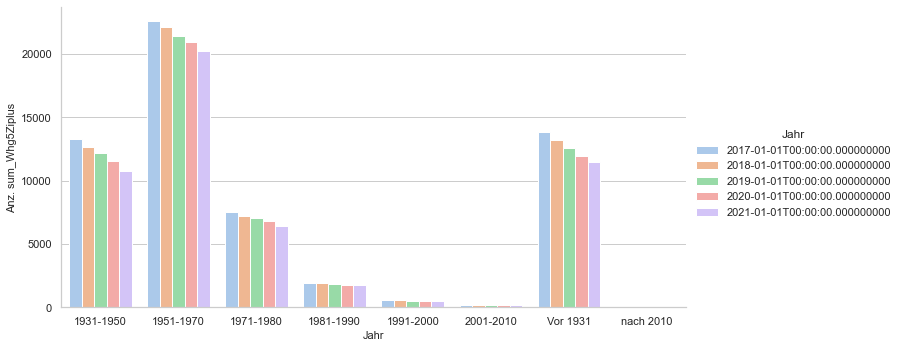

In [39]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Bauperiode"
            , y="sum_AnzHeizöl"
            , hue="Jahr"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Wohnungen', fontsize=11)


#### Entwicklung der Wohnungen, die mit Wärmepumpen geheizt werden seit 2017

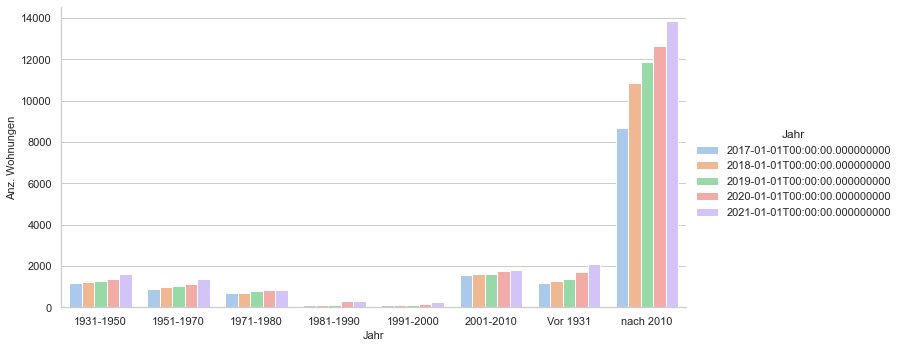

In [43]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Bauperiode"
            , y="sum_AnzWärmepumpen"
            , hue="Jahr"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Wohnungen', fontsize=11)


In [44]:
data2betested.dtypes

StatZoneSort     int64
StatZoneLang    object
QuarSort         int64
QuarLang        object
KreisSort        int64
KreisLang       object
Bauperiode      object
Heizöl           int64
Gas              int64
Holz             int64
Wärmepumpe       int64
Fernwärme        int64
Andere           int64
dtype: object

#### Entwicklung der mit Heizöl geheizten Wohnungen nach Kreis und Bauperiode

In [ ]:
myAggBar = data2betested.loc["2017":"2021"]\
    .groupby(['Jahr','Bauperiode','KreisLang', 'KreisSort']) \
    .agg(sum_AnzHeizöl=('Heizöl', 'sum'),sum_AnzGas=('Gas', 'sum'),sum_Fernwärme=('Fernwärme', 'sum'),sum_AnzWärmepumpen=('Wärmepumpe', 'sum'),sum_AnzHolz=('Holz', 'sum'),sum_AnzAndere=('Andere', 'sum') ) \
    .sort_values('KreisSort', ascending=True) 
#myAggBar.reset_index()

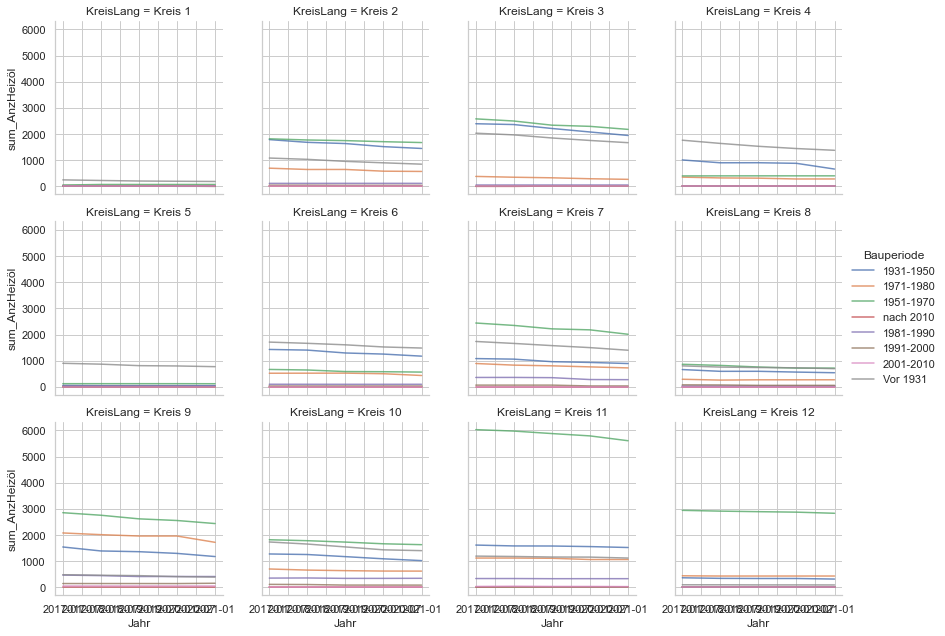

In [ ]:
g = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="Bauperiode", col_wrap=4, height=3,)
#g.map(sns.scatterplot, "sum_Whg1Zi", "sum_Whg4Zi", alpha=.8)
g.map(sns.lineplot, "Jahr","sum_AnzHeizöl",alpha=.8)
g.add_legend()


#### Entwicklung der mit Gas geheizten Wohnungen nach Kreis und Bauperiode

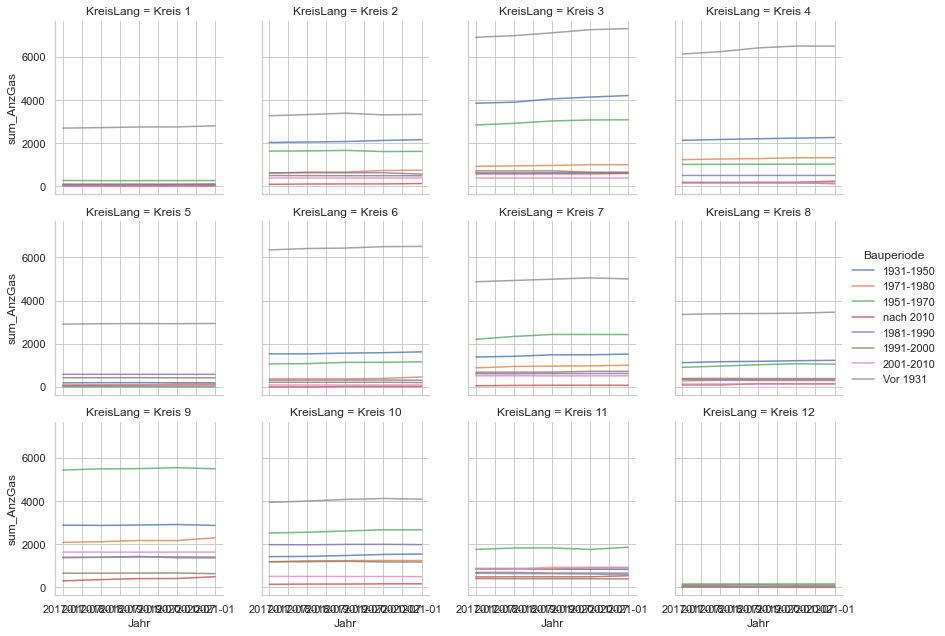

In [69]:
g = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="Bauperiode", col_wrap=4, height=3,)
#g.map(sns.scatterplot, "sum_Whg1Zi", "sum_Whg4Zi", alpha=.8)
g.map(sns.lineplot, "Jahr","sum_AnzGas",alpha=.8)
g.add_legend()


#### Entwicklung der mit Wärmepumpen geheizten Wohnungen nach Kreis und Bauperiode

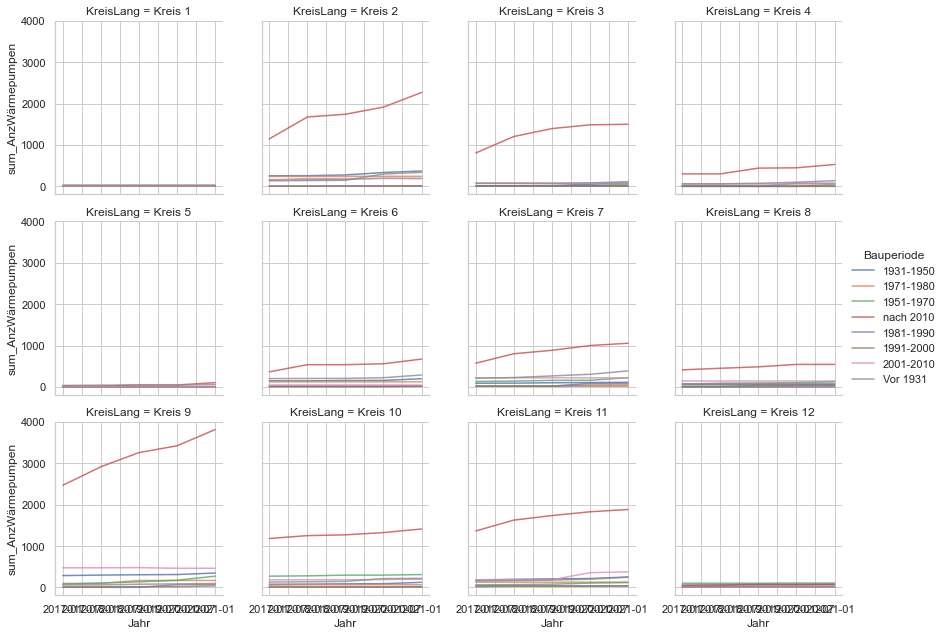

In [49]:
g = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="Bauperiode", col_wrap=4, height=3,)
#g.map(sns.scatterplot, "sum_Whg1Zi", "sum_Whg4Zi", alpha=.8)
g.map(sns.lineplot, "Jahr","sum_AnzWärmepumpen",alpha=.8)
g.add_legend()


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Mit Heizöl geheizte Wohnungen nach Kreis, Quartier und Bauperiode 2021

In [55]:
#data2betested.dtypes

In [73]:
myTreemapAgg = data2betested.loc["2021"]\
    .groupby(['Bauperiode','KreisLang', 'KreisSort','QuarLang', 'QuarSort']) \
    .agg(sum_AnzHeizöl=('Heizöl', 'sum'),sum_AnzGas=('Gas', 'sum'),sum_Fernwärme=('Fernwärme', 'sum'),sum_AnzWärmepumpen=('Wärmepumpe', 'sum'),sum_AnzHolz=('Holz', 'sum'),sum_AnzAndere=('Andere', 'sum') ) \
    .sort_values('KreisSort', ascending=True) 

myTreemapAgg.reset_index().head(3)

,Bauperiode,KreisLang,KreisSort,QuarLang,QuarSort,sum_AnzHeizöl,sum_AnzGas,sum_Fernwärme,sum_AnzWärmepumpen,sum_AnzHolz,sum_AnzAndere
0,1931-1950,Kreis 1,1,City,14,1,13,0,1,0,0
1,1951-1970,Kreis 1,1,Lindenhof,13,1,32,0,0,0,0
2,1951-1970,Kreis 1,1,Rathaus,11,67,197,0,0,0,0


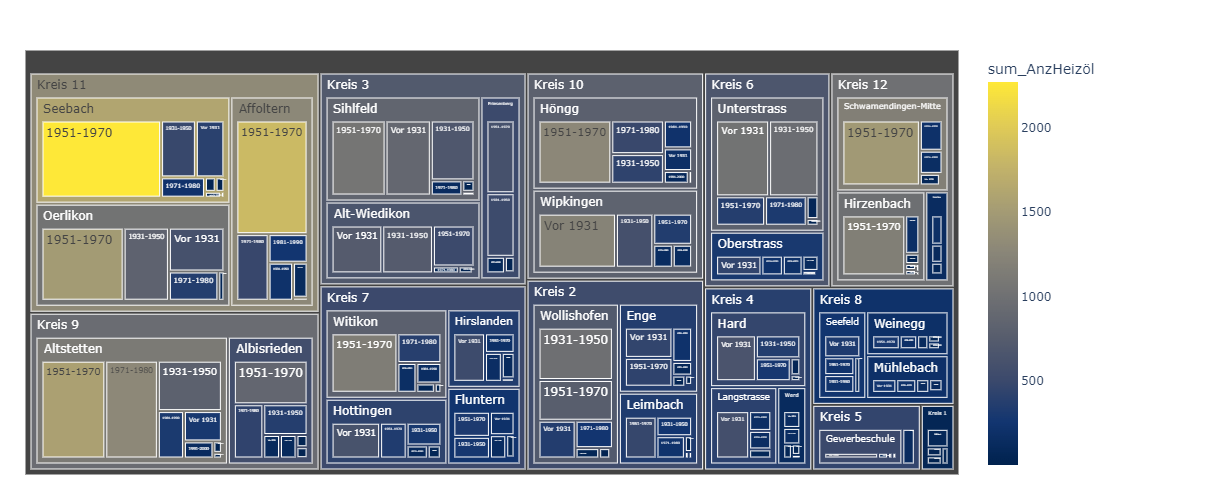

In [74]:
fig = px.treemap(myTreemapAgg.query('sum_AnzHeizöl >0').reset_index(), path=[px.Constant("")
                                                                                     ,'KreisLang', 'QuarLang','Bauperiode']
                 , values='sum_AnzHeizöl'
                 , color='sum_AnzHeizöl'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Mit Heizöl geheizte Wohnungen nach Kreis, Quartier und Bauperiode 2021

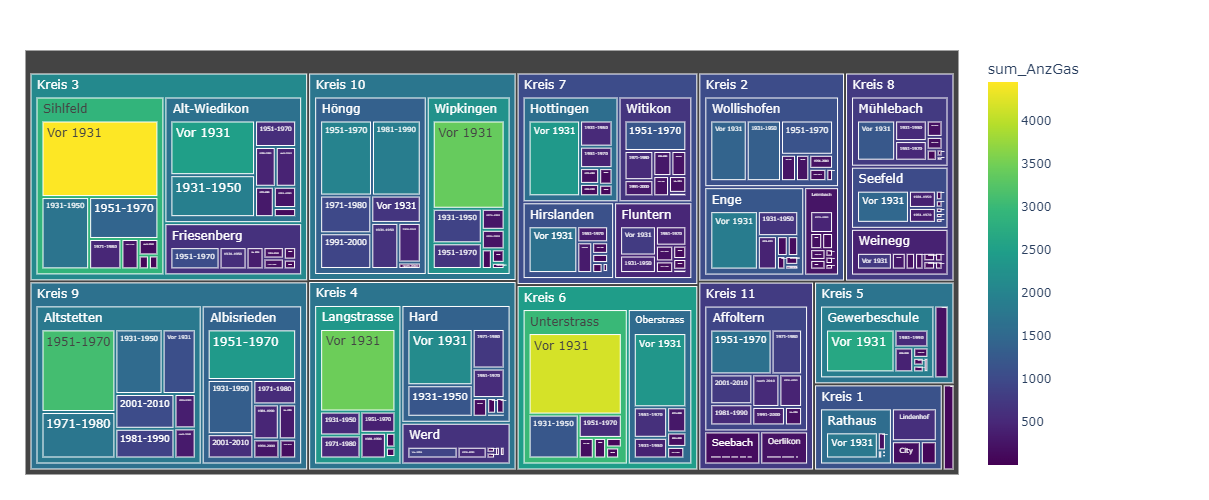

In [78]:
fig = px.treemap(myTreemapAgg.query('sum_AnzGas >0').reset_index(), path=[px.Constant("")
                                                                                     ,'KreisLang', 'QuarLang','Bauperiode']
                 , values='sum_AnzGas'
                 , color='sum_AnzGas'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='viridis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

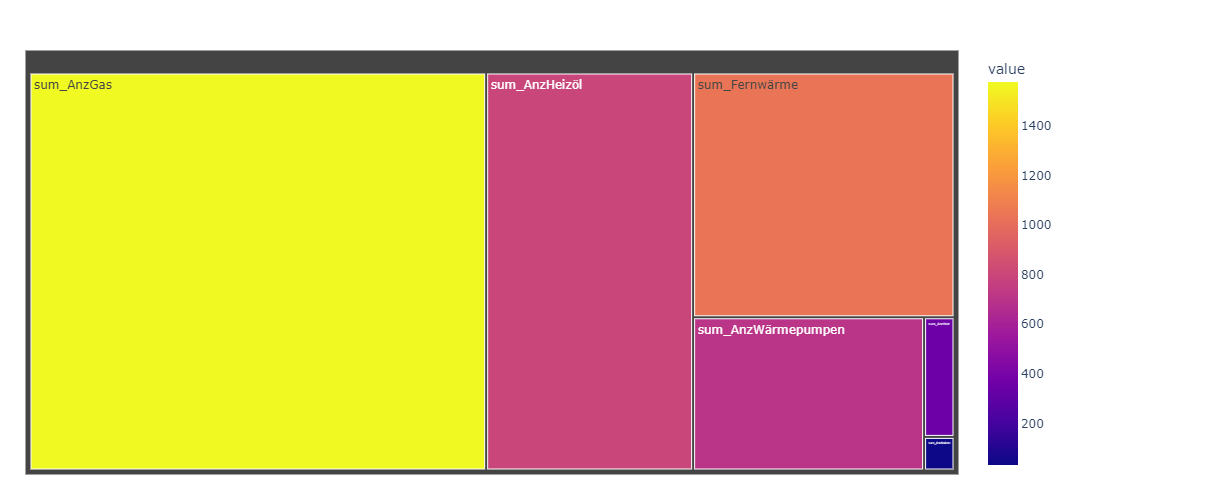

In [79]:
fig = px.treemap(myTreemapAgg.melt().reset_index(), path=[px.Constant("test")
                                                                                     ,'variable']
                 , values='value'
                 , color='value'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [80]:
#data2betested.dtypes

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=463&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [124]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [115]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [119]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

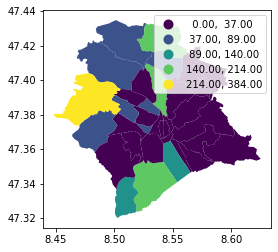

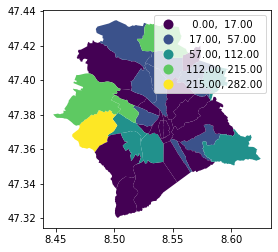

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

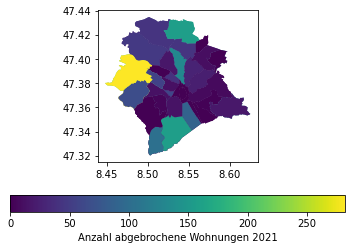

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=463&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**